
### Com os embeddings criados, o próximo desafio é mapear e identificar onde, dentro dessas representações, cada pilar-chave está localizado — como cor, estampa e modelagem.

A ideia é analisar como essas características se manifestam no espaço vetorial dos embeddings. Precisamos descobrir em quais subespaços específicos cada atributo se concentra, de forma que, por exemplo, cores semelhantes tenham vetores próximos dentro do subespaço dedicado à cor. Esse mapeamento permitirá uma separação clara entre os diferentes pilares e facilitará a análise de similaridade e comparação de produtos com base em atributos específicos.

# PILAR DE COR

Vamos começar com foco em identificar o subespaço de cor das roupas.

### Ideias

**Ideia 1: Inclusão de Blocos de Cores Sólidas e PCA**\
Uma abordagem inicial consiste em gerar embeddings a partir de blocos de cores sólidas e descrições genéricas centradas na cor (por exemplo, "roupa de cor amarela"), em conjunto com os embeddings dos produtos. A hipótese é que, ao incluir essas informações no conjunto de dados, poderemos identificar o subespaço relacionado às cores por meio da Análise de Componentes Principais (PCA), verificando se existe um agrupamento claro que capture a variação cromática.

Possíveis testes:

- Gerar embeddings de imagens com cores puras.
- Gerar embeddings de descrições de cores.
- Gerar embeddings com imagens de uma mesma roupa de diferentes cores.

*Comentário: Esta abordagem é interessante pois explora a capacidade do modelo de associar variações puras de cor, aproveitando
a PCA para redução de dimensionalidade e exploração da variância nas dimensões cromáticas.
O desafio será garantir que a cor seja capturada de forma independente de outras características visuais,
como textura ou estampa.*


**Ideia 2: Utilização de PLS-DA com a Cor como Variável Alvo**\
Uma alternativa é utilizar Partial Least Squares (PLS), especificamente o PLS-DA (uma extensão do PLS tradicional adaptada para problemas de classificação, onde a variável dependente é categórica). Nessa abordagem, o objetivo é definir a cor como variável alvo e ajustar os embeddings de modo que as direções no espaço vetorial maximizem a correlação com os valores de cor.

*Comentário: É necessário ter uma variável alvo de cor para cada produto.*


**Alternativa: retreinar o modelo inserindo imagens estratégicas**\
Caso os resultados não sejam positivos, há ainda a possibilidade de fazer um fine-tunnig no CLIP incluindo imagens que ajudem a identificar clusters posteriormente, como cores sólidas.

**Ideia 3: Utilização LDA como redutor com a Cor como Variável Alvo**\
Outra alternativa é utilizar o LDA (Linear Discriminant Analysis) como redutor de dimensionalidade, com a cor como variável alvo. O LDA é um método de redução de dimensionalidade que visa maximizar a separação entre classes, o que pode ser útil para identificar o subespaço de cor.

*Como queremos que as cores estejam o mais separadas possível, o LDA pode ser uma boa opção para identificar o subespaço de cor.*


### Adiantando possíveis impasses:
Precisamos garantir que o subespaço de cor não esteja considerando a cor do fundo e da modelo.

Qual abordagem é mais promissora inicialmente?

1. Primeiro nos preocupamos em testar diferentes técnicas para verificar se o modelo é capaz de identificar a cor independentemente disso.
2. Garantimos inicialmente que estamos olhando apenas para a roupa (excluir modelo e fundo) para só aí tentar identificar o subespaço da cor.(Possível impasse: será que isso piora a capacidade do modelo de reconhecer as roupas já que não tem a modelo como perspectiva e os recortes podem ficar não suaves?)

Uma possível solução seguindo a 2° abordagem seria recortar apenas a roupa e excluir modelo e fundo.

Encontrei uma maneira razoável de fazer isso em <https://colab.research.google.com/drive/1N-Uiq5OqJHxUsVFUcSmbOq0Om9VkK4bH#scrollTo=zeAIoYydgkVk>

Entretanto, apenas com alguns testes já foi possível notar que o modelo pode se perder por conta do recorte. Como o recorte não é suave, acaba interfirindo na cor principal da roupa. Talvez um caminho mais correto seria identificar nos embeddings o subespaço que corresponde a modelo e ao fundo.


*Vamos seguir explorando técnicas com as imagens inteiras e tentar identificar as cores das roupas independentemente.*

## 1° abordagem: PCA

In [1]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image, ImageFile
import requests
import torch

# We use the original clip-ViT-B-32 for encoding images
img_model = SentenceTransformer('clip-ViT-B-32')

# Our text embedding model is aligned to the img_model and maps 50+
# languages to the same vector space
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
c:\Users\Cole\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transfo

In [2]:
# Função para plotar a imagem a partir do caminho
from matplotlib import pyplot as plt
from PIL import Image

def plot_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Descrições personalizadas

In [74]:
import pandas as pd

# Importanto embeddings das imagens
df_img_embs = pd.read_parquet('datasets/img_embeddings.parquet')

In [75]:
df_img_embs.sample(3)

id_produto  emb_img_0  emb_img_1  emb_img_2  emb_img_3  emb_img_4  \
507  25-34-1619-04501  -0.109593  -0.352106  -0.240104   0.515513  -0.414047   
285   52-13-5349-0005   0.012631   0.050747  -0.045989   0.404282   0.119598   
470   52-13-5554-0005  -0.199503  -0.090363  -0.273821   0.235634  -0.045517   

     emb_img_5  emb_img_6  emb_img_7  emb_img_8  ...  emb_img_502  \
507   0.146571  -0.514393  -0.736980   0.465077  ...    -0.040250   
285   0.328273  -0.424087   0.086238   0.609189  ...    -0.035668   
470   0.632836  -0.407793  -0.441105   0.617906  ...    -0.007227   

     emb_img_503  emb_img_504  emb_img_505  emb_img_506  emb_img_507  \
507    -0.213013     0.180362     0.152578    -0.081060    -0.086705   
285    -0.210785     0.552158    -0.045512    -0.003307    -0.272042   
470    -0.210607     0.130949    -0.144696    -0.087390    -0.266236   

     emb_img_508  emb_img_509  emb_img_510  emb_img_511  
507    -0.178832     0.900631    -0.206168     0.111474  
285     0.097800     0.771762    -0.038301     0.015203  
470    -0.346147     1.101424    -0.095921     0.350597  

[3 rows x 513 columns]

In [76]:
df_img_embs.shape

(766, 513)

In [77]:
# Criando lista de descrições puras para cada cor
description_list_pt = [
    'Roupa da cor preta',
    'Roupa da cor branca',
    'Roupa da cor vermelha',
    'Roupa da cor amarela',
    'Roupa da cor verde',
    'Roupa da cor azul',
    'Roupa da cor roxa',
    'Roupa da cor marrom',
    'Roupa da cor rosa',
    'Roupa da cor laranja'
]

description_list = [
    'Black color clothing',
    'White color clothing',
    'Red color clothing',
    'Yellow color clothing',
    'Green color clothing',
    'Blue color clothing',
    'Purple color clothing',
    'Brown color clothing',
    'Pink color clothing',
    'Orange color clothing'
]


cores_embeddings = text_model.encode(description_list)

In [78]:
df_img_embs.head(1)

id_produto  emb_img_0  emb_img_1  emb_img_2  emb_img_3  emb_img_4  \
0  03-04-0464-0030   0.159315  -0.024293  -0.117268   0.017468  -0.192906   

   emb_img_5  emb_img_6  emb_img_7  emb_img_8  ...  emb_img_502  emb_img_503  \
0   0.137711  -0.402171  -0.144309   0.939456  ...    -0.028948    -0.075428   

   emb_img_504  emb_img_505  emb_img_506  emb_img_507  emb_img_508  \
0     0.560166    -0.266601    -0.213009     0.003456      0.25105   

   emb_img_509  emb_img_510  emb_img_511  
0     0.798051    -0.282096     0.032521  

[1 rows x 513 columns]

In [79]:
# Usar PCA nos embs das cores
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
cores_embeddings_pca = pca.fit_transform(cores_embeddings)
cores_embeddings_pca.shape

(10, 2)

In [80]:
df = pd.read_parquet('datasets/base.parquet')

In [81]:
df.sample(5)

file_path        id_produto  \
716  animale_images_cropped/vestido/vestido_vestido...  07-20-6482-09544   
376  animale_images_cropped/blusa/top-blusa_regata-...   52-15-1409-0003   
299  animale_images_cropped/blusa/top-blusa_blusa-d...   52-13-5281-0005   
609  animale_images_cropped/vestido/vestido_vestido...  07-20-6486-09561   
390  animale_images_cropped/blusa/top-blusa_regata-...   52-15-1339-0003   

    grupo_produto                                          file_name  \
716       vestido  vestido_vestido-longo-plissado-frente-unica-es...   
376         blusa  top-blusa_regata-de-malha-rib-com-decote-u_off...   
299         blusa  top-blusa_blusa-de-tricot-preto-com-manga-long...   
609       vestido  vestido_vestido-de-georgette-longo-babados-est...   
390         blusa  top-blusa_regata-de-tricot-com-decote-nadador-...   

                                                  link          PRODUTOS  \
716  https://animaleproductsimages.s3.us-east-1.ama...  07-20-6482-09544   
376  https://animaleproductsimages.s3.us-east-1.ama...   52-15-1409-0003   
299  https://animaleproductsimages.s3.us-east-1.ama...   52-13-5281-0005   
609  https://animaleproductsimages.s3.us-east-1.ama...  07-20-6486-09561   
390  https://animaleproductsimages.s3.us-east-1.ama...   52-15-1339-0003   

                                       CARACTERISTICAS LOCALIZACAO_ESTAMPA  \
716  {COMPRIMENTO_SAIA: CALCANHAR;COMPRIMENTO_MANGA...       ROUPA_INTEIRA   
376  {COMPRIMENTO: CURTA;MODELAGEM: AJUSTADA;COMPRI...                 N/A   
299  {COMPRIMENTO: LONGA;MODELAGEM: AJUSTADA;COMPRI...                 N/A   
609  {COMPRIMENTO_SAIA: CALCANHAR;COMPRIMENTO_MANGA...       ROUPA_INTEIRA   
390  {COMPRIMENTO: LONGA;MODELAGEM: SOLTA;COMPRIMEN...                 N/A   

    COR_PREDOMINANTE DECOTE_OU_GOLA  ...  ESTILO TIPO_MANGA TIPO_CINTURA  \
716            VERDE        REDONDA  ...  CASUAL        N/A         None   
376           BRANCO       QUADRADA  ...  BASICO        N/A         None   
299            PRETO        REDONDA  ...  BASICO    REGULAR         None   
609             AZUL              V  ...  CASUAL        N/A         None   
390        OFF_WHITE              V  ...  BASICO        N/A         None   

    COMPRIMENTO MODELAGEM      ESTAMPA FENDA_PERNA MODELAGEM_SAIA TIPO_BARRA  \
716        None      None       FLORAL         N/A       PLISSADA       None   
376       CURTA  AJUSTADA  SEM_ESTAMPA        None           None       None   
299       LONGA  AJUSTADA  SEM_ESTAMPA        None           None       None   
609        None      None       FLORAL         N/A           GODÊ       None   
390       LONGA     SOLTA  SEM_ESTAMPA        None           None       None   

                                          desc_produto  
716      vestido longo plissado frente unica estampado  
376                   regata de malha rib com decote u  
299   blusa de tricot preto com manga longa metalizado  
609  vestido de georgette longo babados estampado d...  
390         regata de tricot com decote nadador basico  

[5 rows x 24 columns]

In [82]:
# Pegando colunas no formato emb_img_
img_cols = [col for col in df_img_embs.columns if 'emb_img_' in col]
img_embs = df_img_embs[img_cols].values

#### Top 3 cores para cada imagem

In [83]:
import numpy as np
import random

animale_images_cropped/calca/calca_calca-de-crepe-preta-com-sobreposicao-no-cos-e-cinto-forrado_preto_25-34-1509-0005.jpg


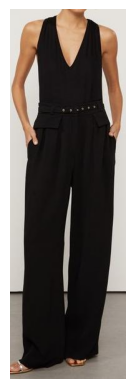

Green color clothing 1.00
White color clothing 0.97
Black color clothing 0.88

animale_images_cropped/calca/calca_calca-duo-off-white_off-white_25-34-1598-0003.jpg


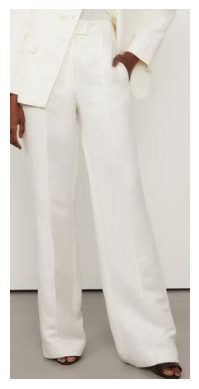

White color clothing 1.00
Black color clothing 0.98
Green color clothing 0.94

animale_images_cropped/blusa/top-blusa_blusa-de-tricot-com-manga-longa-e-gola-alta-slim-preto_preto_52-13-5233-0005.jpg


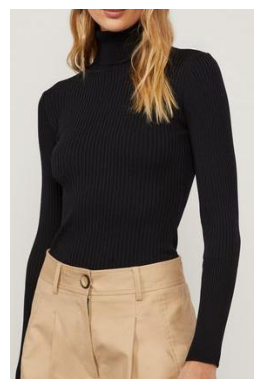

Green color clothing 0.98
White color clothing 0.89
Brown color clothing 0.87

animale_images_cropped/vestido/vestido_vestido-de-couro-curto-decote-quadrado_preto_07-20-5856-0005.jpg


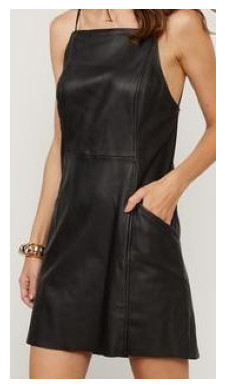

Blue color clothing 0.97
Black color clothing 0.86
White color clothing 0.70

animale_images_cropped/blusa/camisa_camisa-manga-longa-de-sarja-off-white_off-white_52-05-1629-0003.jpg


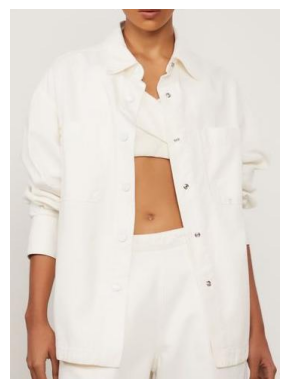

White color clothing 1.00
Green color clothing 0.97
Black color clothing 0.95

animale_images_cropped/saia/saia_saia-midi-com-franzido_preto_25-11-1402-0005.jpg


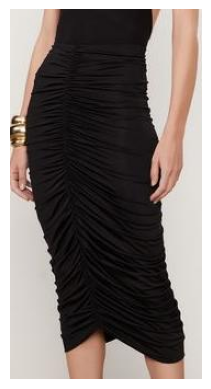

Blue color clothing 1.00
Black color clothing 0.95
White color clothing 0.84

animale_images_cropped/blusa/top-blusa_regata-de-tricot-roxo-com-lurex-long_roxo-mirtilo_52-15-1381-09252.jpg


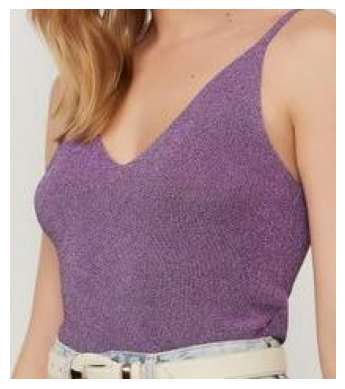

Pink color clothing 0.98
Purple color clothing 0.98
Red color clothing 0.56

animale_images_cropped/blusa/camisa_camisa-de-seda-ampla-preta-manga-longa_preto_52-05-1568-0005.jpg


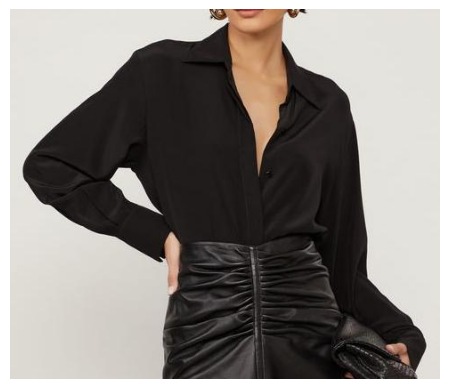

Black color clothing 0.99
Blue color clothing 0.99
White color clothing 0.93

animale_images_cropped/short/short_short-de-sarja-com-detalhe-barra-verde_verde-musgo_25-05-4206-04526.jpg


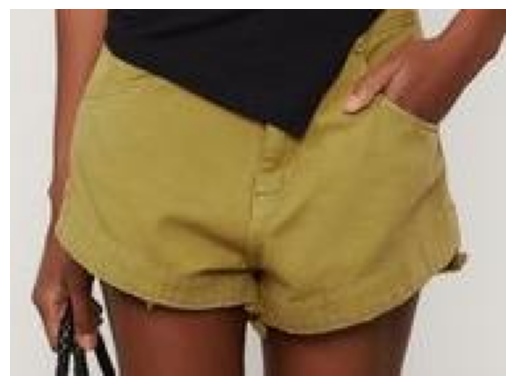

Yellow color clothing 0.99
Brown color clothing 0.87
Orange color clothing 0.73

animale_images_cropped/blazer/blazer_blazer-alongado-marrom-nozes-sem-lapela_marrom-nozes_03-04-0478-6048.jpg


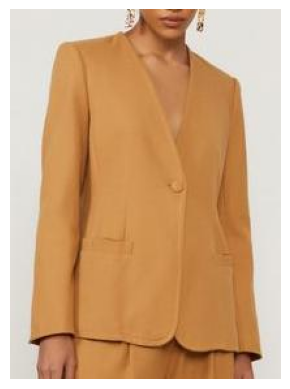

Orange color clothing 1.00
Yellow color clothing 0.82
Red color clothing 0.68



In [84]:
# Embeddings com pca para cores
cores_embeddings_pca = pca.transform(cores_embeddings)

# Aplicando o mesmo PCA nos embs das imagens
img_embeddings_pca = pca.transform(img_embs)

# Pegando 10 imagens aleatórias
sample_indexes = random.sample(range(img_embeddings_pca.shape[0]), 10)
img_embeddings_pca_sample = img_embeddings_pca[sample_indexes]
files = df['file_path'].values[sample_indexes]

# para cada dimensão do vetor de PCA das imagens, escalamos para bater com o mesmo min e max do vetor de cores
for i in range(img_embeddings_pca_sample.shape[1]):
  min_value_color = cores_embeddings_pca[:, i].min()
  max_value_color = cores_embeddings_pca[:, i].max()
  min_value_img = img_embeddings_pca_sample[:, i].min()
  max_value_img = img_embeddings_pca_sample[:, i].max()
  img_embeddings_pca_sample[:, i] = (img_embeddings_pca_sample[:, i] - min_value_img) / (max_value_img - min_value_img) * (max_value_color - min_value_color) + min_value_color


cos_sim = util.cos_sim(img_embeddings_pca_sample, cores_embeddings_pca)

# para cada imagem, vendo a semelhança com cada cor
for file_name, scores in zip(files, cos_sim):
  print(file_name)
  plot_image(file_name)
  # top 3 colors:
  scores = scores.numpy()
  top_3_indices = scores.argsort()
  for i in range(3):
    print(description_list[top_3_indices[-i-1]], f"{scores[top_3_indices[-i-1]]:.2f}")
  print()

### Visualizando as duas primeiras dimensões do PCA

In [85]:
img_embeddings_pca.shape

(766, 2)

In [86]:
# Adicionando img_embeddings_pca ao df
pca_cols = [f'pca_{i}' for i in range(img_embeddings_pca.shape[1])]
print(pca_cols)
df[pca_cols] = img_embeddings_pca
print(f"df.shape: {df.shape}")
df.head(1)

['pca_0', 'pca_1']
df.shape: (766, 26)


file_path       id_produto  \
0  animale_images_cropped/blazer/blazer_blazer-al...  03-04-0464-0030   

  grupo_produto                                          file_name  \
0        blazer  blazer_blazer-alfaiataria-est-onca-jacquard_be...   

                                                link         PRODUTOS  \
0  https://animaleproductsimages.s3.us-east-1.ama...  03-04-0464-0030   

                                     CARACTERISTICAS LOCALIZACAO_ESTAMPA  \
0  {COMPRIMENTO: MEDIO;MODELAGEM: AJUSTADA;COMPRI...       ROUPA_INTEIRA   

  COR_PREDOMINANTE DECOTE_OU_GOLA  ... TIPO_CINTURA COMPRIMENTO MODELAGEM  \
0             BEGE           None  ...         None       MEDIO  AJUSTADA   

            ESTAMPA FENDA_PERNA MODELAGEM_SAIA TIPO_BARRA  \
0  ANIMALPRINT_ONCA        None           None       None   

                           desc_produto    pca_0     pca_1  
0  blazer alfaiataria est onca jacquard -0.96027 -0.387323  

[1 rows x 26 columns]

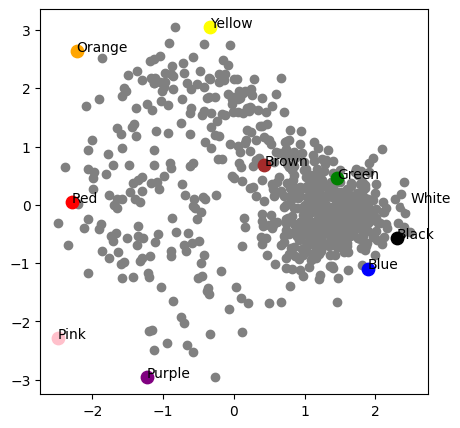

In [89]:
# Plot com as dimensões do PCA(X a dimensão 0, Y a dimensão 1) -usando apenas as duas primeiras dimensões de cores_embeddings_pca
plt.figure(figsize=(5, 5))

# Plotando alguns exemplos de imagens nesse plot de cores
sample = img_embeddings_pca

# para cada dimensão do vetor de PCA das imagens, escalamos para bater com o mesmo min e max do vetor de cores
for i in range(sample.shape[1]):
  min_value_color = cores_embeddings_pca[:, i].min()
  max_value_color = cores_embeddings_pca[:, i].max()
  min_value_img = sample[:, i].min()
  max_value_img = sample[:, i].max()
  sample[:, i] = (sample[:, i] - min_value_img) / (max_value_img - min_value_img) * (max_value_color - min_value_color) + min_value_color


for i, (x, y) in enumerate(sample[:, :2]):
    plt.scatter(x, y, color='gray')

for i, (x, y) in enumerate(cores_embeddings_pca[:, :2]):
    color = description_list[i].replace(" color clothing", "").replace("Roupa da cor ", "")
    # plotting colored according to the color value
    plt.scatter(x, y, color=color, s=80)
    plt.text(x, y, color)


### Testando em 3d

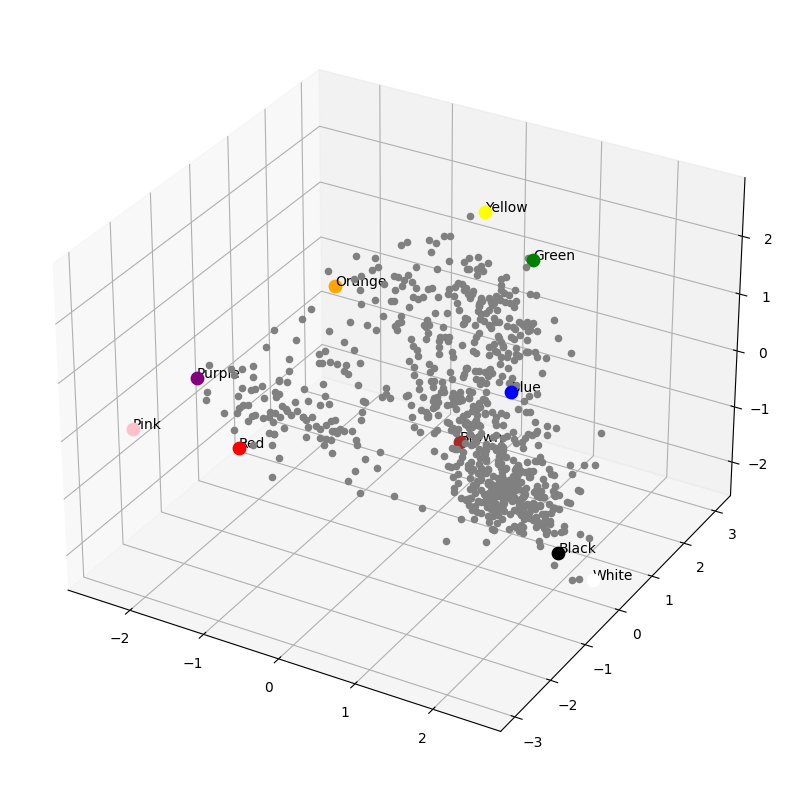

In [91]:
# Refazendo PCA com 3 dimensões
pca = PCA(n_components=3)
cores_embeddings_pca = pca.fit_transform(cores_embeddings)
img_embeddings_pca = pca.transform(img_embs)

sample = img_embeddings_pca

# para cada dimensão do vetor de PCA das imagens, escalamos para bater com o mesmo min e max do vetor de cores
for i in range(sample.shape[1]):
  min_value_color = cores_embeddings_pca[:, i].min()
  max_value_color = cores_embeddings_pca[:, i].max()
  min_value_img = sample[:, i].min()
  max_value_img = sample[:, i].max()
  sample[:, i] = (sample[:, i] - min_value_img) / (max_value_img - min_value_img) * (max_value_color - min_value_color) + min_value_color

cos_sim = util.cos_sim(sample, cores_embeddings_pca)

# Plot 3d com as dimensões do PCA(X a dimensão 0, Y a dimensão 1, Z a dimensão 2) -usando as três primeiras dimensões de cores_embeddings_pca

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i, (x, y, z) in enumerate(sample[:, :3]):
    ax.scatter(x, y, z, color='gray')

for i, (x, y, z) in enumerate(cores_embeddings_pca[:, :3]):
    color = description_list[i].replace(" color clothing", "").replace("Roupa da cor ", "")
    # plotting colored according to the color value
    ax.scatter(x, y, z, color=color, s=80)
    ax.text(x, y, z, color)


animale_images_cropped/blusa/top-blusa_top-de-couro-franzido-amarracao_preto_52-10-5260-0005.jpg


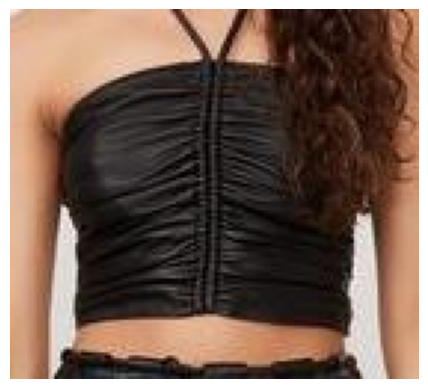

Black color clothing 0.90
White color clothing 0.77
Blue color clothing 0.56

animale_images_cropped/blusa/top-blusa_blusa-tricot-oversized-com-transparencia_verde-cha_52-13-5324-04356.jpg


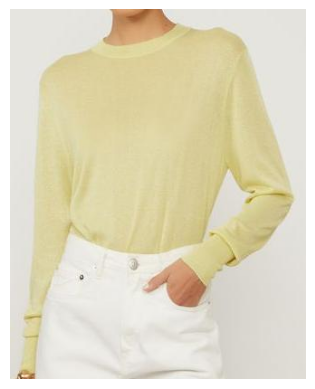

Yellow color clothing 0.90
Green color clothing 0.81
Orange color clothing 0.35

animale_images_cropped/saia/saia_saia-drapeada-de-seda-azul-hortensia_azul-hortensia_25-34-1619-04501.jpg


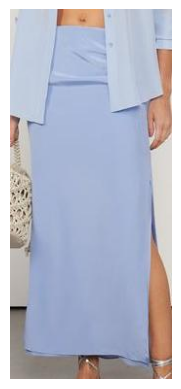

Purple color clothing 0.82
Blue color clothing 0.79
Green color clothing 0.42

animale_images_cropped/blusa/top-blusa_regata-de-tricot-vermelha-com-gola-u-canelado_vermelho-fiery_52-15-1370-8259.jpg


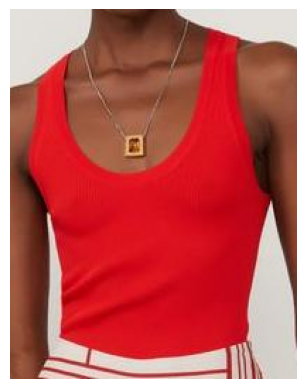

Orange color clothing 0.95
Red color clothing 0.79
Yellow color clothing 0.45

animale_images_cropped/vestido/vestido_vestido-de-malha-crepe-midi-marrom-ombro-a-ombro-cruzado_marrom-nozes_07-20-6613-6048.jpg


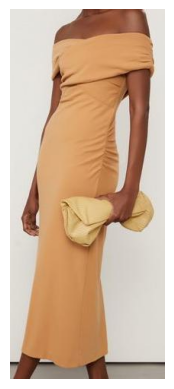

Yellow color clothing 0.98
Orange color clothing 0.83
Green color clothing 0.33

animale_images_cropped/blusa/top-blusa_top-de-tricot-faixa-cruzado-basic_preto_52-10-5210-0005.jpg


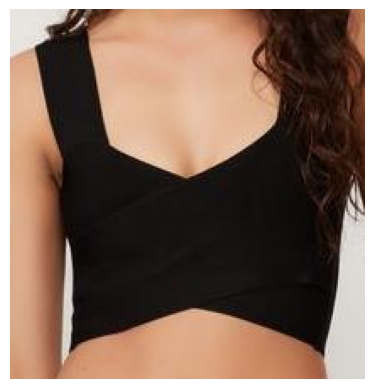

Black color clothing 0.87
White color clothing 0.77
Blue color clothing 0.38

animale_images_cropped/saia/saia_saia-midi-bordada-garden_bege-whitecap_25-11-1190-04346.jpg


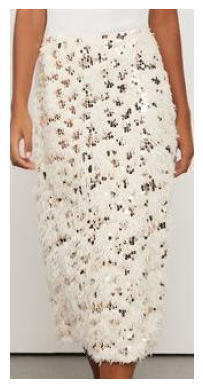

Black color clothing 0.82
White color clothing 0.77
Brown color clothing 0.40

animale_images_cropped/vestido/vestido_vestido-de-algodao-midi_bege-flan_07-20-6736-09276.jpg


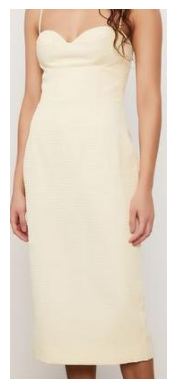

Black color clothing 0.99
White color clothing 0.96
Brown color clothing 0.61

animale_images_cropped/blusa/camisa_camisa-de-tricoline-essencial-branca_branco_52-05-1585-0002.jpg


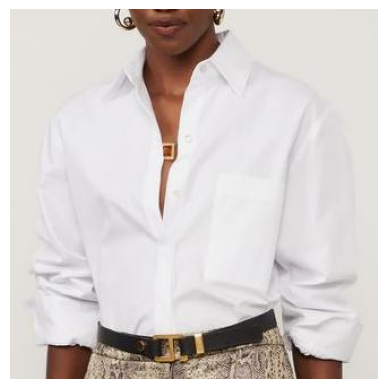

Black color clothing 0.99
White color clothing 0.97
Brown color clothing 0.64

animale_images_cropped/blazer/blazer_blazer-de-couro-acinturado-botoes-organicos_bege-whitecap_03-01-1628-04346.jpg


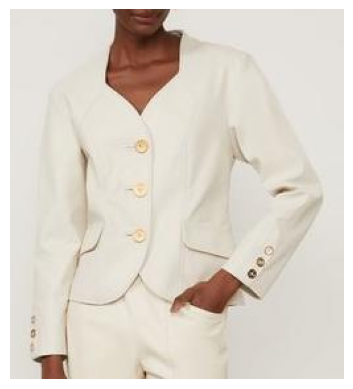

Black color clothing 0.97
White color clothing 0.88
Blue color clothing 0.55



In [97]:
sample_indexes = random.sample(range(sample.shape[0]), 10)
img_embeddings_pca_sample = img_embeddings_pca[sample_indexes]
files = df['file_path'].values[sample_indexes]

# para cada dimensão do vetor de PCA das imagens, escalamos para bater com o mesmo min e max do vetor de cores
for i in range(img_embeddings_pca_sample.shape[1]):
  min_value_color = cores_embeddings_pca[:, i].min()
  max_value_color = cores_embeddings_pca[:, i].max()
  min_value_img = img_embeddings_pca_sample[:, i].min()
  max_value_img = img_embeddings_pca_sample[:, i].max()
  img_embeddings_pca_sample[:, i] = (img_embeddings_pca_sample[:, i] - min_value_img) / (max_value_img - min_value_img) * (max_value_color - min_value_color) + min_value_color


cos_sim = util.cos_sim(img_embeddings_pca_sample, cores_embeddings_pca)

# Vendo top 3 cores mais próximas para um sample de imagens
for file_name, scores in zip(files, cos_sim):
  print(file_name)
  plot_image(file_name)
  # top 3 colors:
  scores = scores.numpy()
  top_3_indices = scores.argsort()
  for i in range(3):
    print(description_list[top_3_indices[-i-1]], f"{scores[top_3_indices[-i-1]]:.2f}")
  print()

Insights:

- O modelo entende melhor algumas cores em inglês, como o purple (não identificou como roxo).
- O modelo não está compreendendo a cor preta
- Branco e preto estão muito próximos, talvez porque a descrição foi textual? (se usarmos imagens será que melhora?)
- Precisamos de um jeito de recortar o grupo da roupa que queremos analisar (Olhar só pra calça, por exemplo)

### Imagens personalizadas: bloco de cores

In [115]:
import os

# Agora, vamos gerar os embeddings das imagens das cores (color_images)
pasta = "color_images"

# Criando lista com as image_paths da pasta
image_paths = [os.path.join(pasta, path).replace('\\','/') for path in os.listdir(pasta)]

# Criando um df_color com os nomes das imagens
df_color = pd.DataFrame(image_paths, columns=["image_path"])
df_color["color_name"] = df_color["image_path"].apply(lambda x: x.split("/")[-1].split(".")[0])

In [116]:
# Criando colunas para os embeddings
emb_columns = [f"emb_img_{i}" for i in range(512)]

# Now we load and encode the images
def load_image(url_or_path):
    if url_or_path.startswith("http://") or url_or_path.startswith("https://"):
        return Image.open(requests.get(url_or_path, stream=True).raw)
    else:
        return Image.open(url_or_path)

file_names = df_color['image_path'].values
images = [load_image(img) for img in file_names]
img_embeddings = img_model.encode(images)

# Colocando os embeddings no df
emb_dict = {}
for i, emb in enumerate(img_embeddings):
    emb_id = df_color.iloc[i]["color_name"]
    emb_dict[emb_id] = emb

df_color_embs = pd.DataFrame(emb_dict).T

df_color_embs.columns = emb_columns
df_color_embs["color_name"] = df_color_embs.index

df_color_embs = df_color_embs.reset_index(drop=True)[["color_name"] + emb_columns]

In [128]:
df_color_embs

color_name  emb_img_0  emb_img_1  emb_img_2  emb_img_3  emb_img_4  \
0   COR AMARELO  -0.028546  -0.025496  -0.417673  -0.056401  -0.140226   
1      COR AZUL   0.006238  -0.045781  -0.431332  -0.097486  -0.076914   
2    COR BRANCO  -0.073344  -0.132770   0.253046  -0.082826   0.171033   
3   COR LARANJA  -0.082441  -0.087324  -0.115958  -0.285204  -0.273470   
4    COR MARROM   0.129687  -0.148728  -0.106386  -0.164460   0.040059   
5     COR PRETO  -0.150350  -0.263389  -0.565511  -0.072226   0.155786   
6      COR ROSA  -0.232607  -0.244402  -0.232435  -0.443345  -0.170635   
7      COR ROXO  -0.040682  -0.236614  -0.166357  -0.177385  -0.007183   
8     COR VERDE   0.041701  -0.172500  -0.322558  -0.331832  -0.085318   
9  COR VERMELHO   0.002639  -0.210456  -0.319800  -0.206563  -0.054426   

   emb_img_5  emb_img_6  emb_img_7  emb_img_8  ...  emb_img_502  emb_img_503  \
0  -0.443518  -0.168441   1.078504  -0.078835  ...     0.232356     0.274418   
1  -0.385147  -0.291344   1.304192   0.383190  ...     0.180391     0.044304   
2  -0.083862  -0.289973   1.193479  -0.287285  ...     0.279241    -0.072687   
3  -0.187084  -0.188147   1.037961   0.035577  ...     0.334134     0.222016   
4  -0.307845  -0.089132   0.950700  -0.319955  ...     0.173314     0.059059   
5  -0.043085  -0.387121   1.272081   0.283594  ...    -0.079255     0.158420   
6  -0.438234  -0.085661   1.015443   0.581087  ...     0.050129    -0.196673   
7  -0.484710  -0.252690   0.917476   0.151761  ...     0.206618     0.219410   
8  -0.456009  -0.269159   1.154621  -0.010214  ...     0.428415     0.234530   
9  -0.474577  -0.110277   1.187309   0.389176  ...     0.233479     0.212013   

   emb_img_504  emb_img_505  emb_img_506  emb_img_507  emb_img_508  \
0     0.405922    -0.071532    -0.292983     0.232331    -0.101903   
1     0.326409    -0.031872    -0.116065     0.203804    -0.297466   
2     0.708488    -0.181231    -0.050427    -0.001854    -0.256473   
3     0.296361     0.105041    -0.340744     0.146224    -0.089053   
4     0.779322     0.071892    -0.055109     0.132718    -0.255734   
5     0.648814     0.091011    -0.028377    -0.349301    -0.134815   
6     0.175514    -0.057394     0.017285     0.326810    -0.417590   
7     0.186061    -0.069840    -0.291403     0.162623    -0.207237   
8     0.443848    -0.184218    -0.117773    -0.014541    -0.146755   
9     0.133250    -0.031382    -0.130833     0.189375    -0.217279   

   emb_img_509  emb_img_510  emb_img_511  
0     0.777710     0.010010    -0.121242  
1     0.716893    -0.139596    -0.128783  
2     0.840973    -0.169232    -0.228157  
3     0.782470    -0.034351    -0.270654  
4     0.735227    -0.228709    -0.160291  
5     0.772287    -0.364340    -0.293392  
6     0.759208    -0.005309     0.089440  
7     0.765841    -0.102973     0.039640  
8     0.745211    -0.273161    -0.027780  
9     0.767863    -0.050193    -0.035196  

[10 rows x 513 columns]

In [129]:
# Pegando só as colunas de embeddings de df_color_embs
color_img_cols = [col for col in df_color_embs.columns if 'emb_img_' in col]
cores_embeddings = df_color_embs[color_img_cols].values

# Usar PCA nos embs das cores
pca = PCA(n_components=2)
cores_embeddings_pca = pca.fit_transform(cores_embeddings)
img_embeddings_pca = pca.transform(img_embs)
cores_embeddings_pca.shape

(10, 2)

In [130]:
df_img_embs

id_produto  emb_img_0  emb_img_1  emb_img_2  emb_img_3  emb_img_4  \
0     03-04-0464-0030   0.159315  -0.024293  -0.117268   0.017468  -0.192906   
1     03-04-0478-6048  -0.054035   0.210889   0.121748   0.122241  -0.188613   
2     03-04-0460-0003  -0.055339   0.376676   0.194497   0.267525  -0.240985   
3     03-04-0461-0005  -0.039712   0.253769   0.223714   0.024840  -0.001702   
4     03-04-0479-0024  -0.108800   0.091291   0.057245   0.337540   0.081135   
..                ...        ...        ...        ...        ...        ...   
761   07-20-6778-0005   0.019623   0.102202  -0.036990   0.455425  -0.337472   
762  07-20-6402-09248   0.100392  -0.032767  -0.091637   0.404944  -0.598882   
763   07-20-6401-0005   0.166221  -0.189078  -0.312695   0.481503  -0.309427   
764  07-20-6659-09538   0.167080  -0.391681  -0.015006   0.289606  -0.200403   
765   07-20-5723-0005   0.194772  -0.072584  -0.330385   0.212128   0.051120   

     emb_img_5  emb_img_6  emb_img_7  emb_img_8  ...  emb_img_502  \
0     0.137711  -0.402171  -0.144309   0.939456  ...    -0.028948   
1     0.181957  -0.546432  -0.593038   0.491988  ...    -0.078863   
2     0.248852  -0.274237  -0.295000   0.566380  ...    -0.101799   
3     0.225233  -0.487728   0.329303   0.675198  ...    -0.054398   
4    -0.222907  -0.204011   0.349029   0.904539  ...     0.211785   
..         ...        ...        ...        ...  ...          ...   
761   0.351344  -0.092960   0.389567   0.625612  ...    -0.169518   
762   0.194458  -0.408226  -0.579717   0.427830  ...    -0.130489   
763   0.435620  -0.162573   0.445066   0.260107  ...    -0.256586   
764   0.050729  -0.315043  -1.028018   0.580867  ...     0.069929   
765   0.244269  -0.355681  -0.792065   0.542854  ...    -0.108337   

     emb_img_503  emb_img_504  emb_img_505  emb_img_506  emb_img_507  \
0      -0.075428     0.560166    -0.266601    -0.213009     0.003456   
1      -0.138086     0.505052    -0.106603    -0.323217     0.086038   
2       0.288448     0.961003    -0.158184    -0.075985    -0.393318   
3      -0.092576     0.788266    -0.300475    -0.480824     0.114495   
4       0.094541     0.865604     0.263496    -0.160512    -0.463765   
..           ...          ...          ...          ...          ...   
761    -0.099625     0.346413    -0.277054     0.040731    -0.580248   
762    -0.199756     0.095518     0.122175    -0.062147    -0.073805   
763    -0.288520     0.117256     0.030498    -0.306072    -0.199355   
764    -0.363056     0.518750     0.049510    -0.099344    -0.377340   
765    -0.182120     0.183112     0.184632     0.102709    -0.237978   

     emb_img_508  emb_img_509  emb_img_510  emb_img_511  
0       0.251050     0.798051    -0.282096     0.032521  
1       0.390587     0.986789    -0.125528     0.456620  
2       0.039428     0.660712    -0.019683    -0.080595  
3       0.257658     0.308829    -0.102123     0.451775  
4       0.182257     0.214232    -0.032568    -0.254120  
..           ...          ...          ...          ...  
761    -0.106754     0.754394    -0.125312     0.119866  
762     0.037836     0.989817    -0.157222     0.231829  
763     0.063874     0.299538    -0.106902    -0.006913  
764     0.139283     1.364434    -0.356402     0.571959  
765     0.004285     1.170011     0.045670     0.236573  

[766 rows x 513 columns]

In [131]:
# Pegando as colunas de embeddings de df_img_embs
img_cols = [col for col in df_img_embs.columns if 'emb_img_' in col]
img_embs = df_img_embs[img_cols].values

In [132]:
img_embs.shape

(766, 512)

animale_images_cropped/blusa/top-blusa_t-shirt-de-tricot-preto-com-decote-redondo-lurex_preto_52-06-0632-0005.jpg


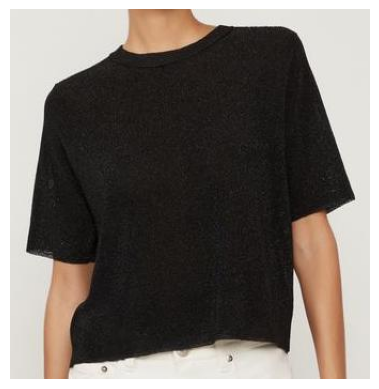

COR PRETO 1.00
COR AZUL 0.99
COR BRANCO 0.32

animale_images_cropped/blusa/top-blusa_t-shirt-de-malha-com-manga-curta_preto_52-06-0680-0005.jpg


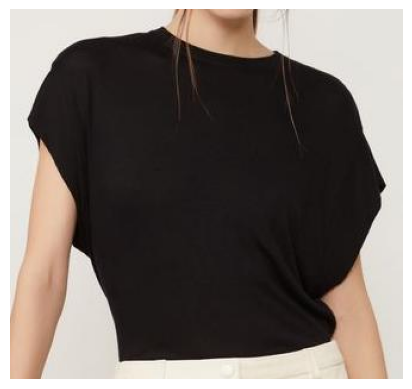

COR AZUL 1.00
COR PRETO 0.98
COR BRANCO 0.44

animale_images_cropped/blusa/top-blusa_t-shirt-de-tricot-amarelo-basico-com-gola-alta_amarelo-golden_52-06-0652-6262.jpg


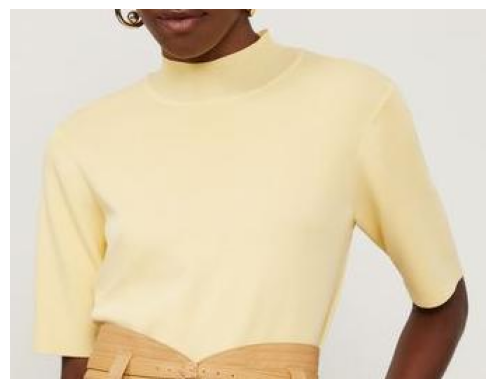

COR AMARELO 0.91
COR LARANJA 0.90
COR MARROM 0.68

animale_images_cropped/blazer/blazer_blazer-com-transpasse-de-crepe-off-white_off-white_03-04-0479-0024.jpg


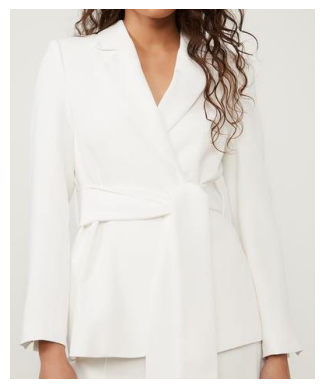

COR PRETO 1.00
COR AZUL 0.97
COR BRANCO 0.22

animale_images_cropped/blusa/top-blusa_tunica-sem-alca-preta-com-ziper-costas_preto_52-13-5378-0005.jpg


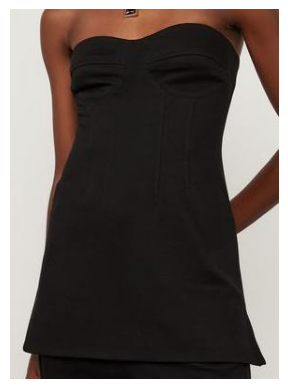

COR PRETO 1.00
COR AZUL 0.99
COR BRANCO 0.33

animale_images_cropped/blazer/blazer_blazer-uno-bege-madeira_bege-madeira_03-04-0467-0800.jpg


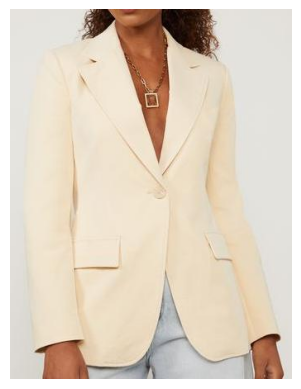

COR AZUL 0.90
COR PRETO 0.81
COR BRANCO 0.78

animale_images_cropped/blusa/camisa_camisa-de-renda-marrom-nozes-com-recorte_marrom-nozes_52-05-1539-6048.jpg


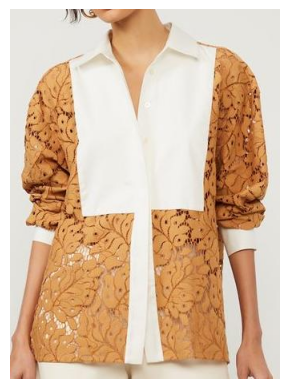

COR BRANCO 0.95
COR AZUL 0.70
COR PRETO 0.55

animale_images_cropped/blusa/top-blusa_top-de-tricot-azul-com-decote-quadrado_azul-oceanico_52-13-5363-09245.jpg


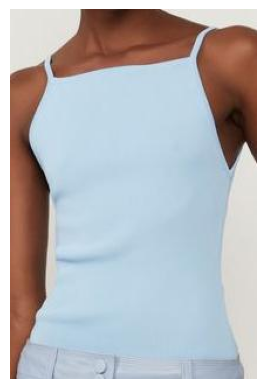

COR AZUL 0.98
COR PRETO 0.94
COR BRANCO 0.59

animale_images_cropped/vestido/vestido_vestido-de-seda-midi-preto-borda-festone_preto_07-20-6810-0005.jpg


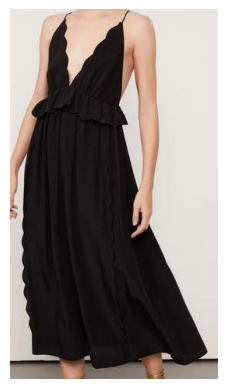

COR PRETO 0.67
COR AZUL 0.52
COR VERMELHO 0.48

animale_images_cropped/calca/calca_calca-de-georgette-pesado-ampla-preta-cos-com-alfinete_preto_25-34-1720-0005.jpg


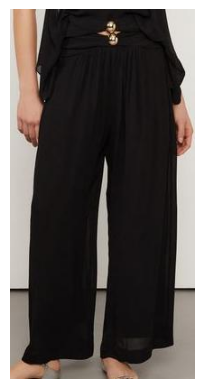

COR AZUL 1.00
COR PRETO 0.99
COR BRANCO 0.37



In [133]:
sample_indexes = random.sample(range(img_embs.shape[0]), 10)
img_embeddings_pca_sample = img_embeddings_pca[sample_indexes]
files = df['file_path'].values[sample_indexes]

# para cada dimensão do vetor de PCA das imagens, escalamos para bater com o mesmo min e max do vetor de cores
for i in range(img_embeddings_pca_sample.shape[1]):
  min_value_color = cores_embeddings_pca[:, i].min()
  max_value_color = cores_embeddings_pca[:, i].max()
  min_value_img = img_embeddings_pca_sample[:, i].min()
  max_value_img = img_embeddings_pca_sample[:, i].max()
  img_embeddings_pca_sample[:, i] = (img_embeddings_pca_sample[:, i] - min_value_img) / (max_value_img - min_value_img) * (max_value_color - min_value_color) + min_value_color


cos_sim = util.cos_sim(img_embeddings_pca_sample, cores_embeddings_pca)

# para cada imagem, vendo a semelhança com cada cor
for file_name, scores in zip(files, cos_sim):
  print(file_name)
  plot_image(file_name)
  # top 3 colors:
  scores = scores.numpy()
  top_3_indices = scores.argsort()
  for i in range(3):
    print(df_color.iloc[top_3_indices[-i-1]]['color_name'], f"{scores[top_3_indices[-i-1]]:.2f}")
  print()

In [134]:
import plotly.graph_objs as go

# refazendo PCA com 3 dimensões
pca = PCA(n_components=3)
cores_embeddings_pca = pca.fit_transform(cores_embeddings)
img_embeddings_pca = pca.transform(img_embs)

# para cada dimensão do vetor de PCA das imagens, escalamos para bater com o mesmo min e max do vetor de cores
for i in range(img_embeddings_pca.shape[1]):
    min_value_color = cores_embeddings_pca[:, i].min()
    max_value_color = cores_embeddings_pca[:, i].max()
    min_value_img = img_embeddings_pca[:, i].min()
    max_value_img = img_embeddings_pca[:, i].max()
    img_embeddings_pca[:, i] = (img_embeddings_pca[:, i] - min_value_img) / (max_value_img - min_value_img) * (max_value_color - min_value_color) + min_value_color

color_dict = { # dicionario para obter as cores em ingles para pintar corretamente o grafico
    "AMARELO": "yellow",
    "AZUL": "blue",
    "BRANCO": "white",
    "LARANJA": "orange",
    "MARROM": "brown",
    "PRETO": "black",
    "ROSA": "pink",
    "ROXO": "purple",
    "VERDE": "green",
    "VERMELHO": "red"
}

# Plotly figure
fig = go.Figure()

# Adding gray image points with hover to show the actual image
for i in range(img_embeddings_pca.shape[0]):
    img_description = df.iloc[i]['desc_produto']
    fig.add_trace(go.Scatter3d(
        x=[img_embeddings_pca[i, 0]],
        y=[img_embeddings_pca[i, 1]],
        z=[img_embeddings_pca[i, 2]],
        mode='markers',
        marker=dict(size=5, color='gray'),
        name=f'Image {i}',
        text=img_description,
        hoverinfo='text'
    ))

# Adding color points
for i in range(cores_embeddings_pca.shape[0]):
    color = df_color.iloc[i]['color_name'].split(" ")[1]
    color = color_dict[color]
    fig.add_trace(go.Scatter3d(
        x=[cores_embeddings_pca[i, 0]],
        y=[cores_embeddings_pca[i, 1]],
        z=[cores_embeddings_pca[i, 2]],
        mode='markers+text',
        marker=dict(size=8, color=color),
        name=f'Color {color}',
        text=color,
        hoverinfo='text'
    ))

# Update layout for better visualization
fig.update_layout(
    title="3D PCA Embeddings of Images and Colors",
    scene=dict(
        xaxis_title="PCA Dimension 1",
        yaxis_title="PCA Dimension 2",
        zaxis_title="PCA Dimension 3"
    ),
    showlegend=False
)

# Show the plot
fig.show()


Insights:

- Mesmo com a padronização, as cores ainda estão muito próximas no espaço. É desejável transformar o espaço das cores base para distribuí-las mais uniformemente. 

- Uma alternativa, como mencionado anteriormente, seria realizar um finetunning com as imagens das roupas coloridas para seja possível compreender melhor as cores e clusterizar os produtos (tarefa não trivial)

## 2° Abordagem: LDA